In [1]:
from blimpy import Waterfall
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools, json
from astropy.stats.sigma_clipping import sigma_clip
from scipy.optimize import curve_fit
from scipy.interpolate import make_splrep
import scipy
from scipy import signal
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker

numexpr.utils   INFO     Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
numexpr.utils   INFO     NumExpr defaulting to 8 threads.


In [2]:
from blimpy import Waterfall

filename = 'Clipped.spliced_blc0001020304050607_guppi_57571_78180_HIP45653_0042.gpuspec.0002.h5'
fil = Waterfall(filename)

In [3]:
print(dir(fil))

['_Waterfall__load_data', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_blob_dimensions', '_get_chunk_dimensions', '_init_alternate', '_update_header', 'beam_axis', 'blank_dc', 'calc_n_coarse_chan', 'calibrate_band_pass_N1', 'container', 'data', 'ext', 'file_header', 'file_shape', 'file_size_bytes', 'filename', 'freq_axis', 'get_freqs', 'grab_data', 'header', 'info', 'logger', 'n_channels_in_file', 'n_ints_in_file', 'plot_all', 'plot_kurtosis', 'plot_spectrum', 'plot_spectrum_min_max', 'plot_time_series', 'plot_waterfall', 'read_data', 'selection_shape', 'stokes_axis', 'time_axis', 'write_to_fil', 'write_to_hdf5']


/home/long/anaconda3/lib/python3.12/site-packages/blimpy/utils.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x + offset)


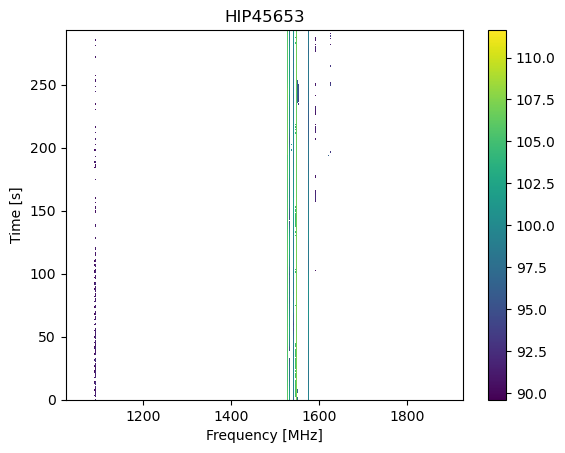

In [4]:
%matplotlib inline
fil.plot_waterfall()
plt.show()

In [5]:
freqs = np.array(fil.freqs)
data = np.array(fil.data)[:,0,:]
time = np.array(fil.timestamps)

print(freqs.shape, data.shape,time.shape)

(315392,) (273, 315392) (273,)


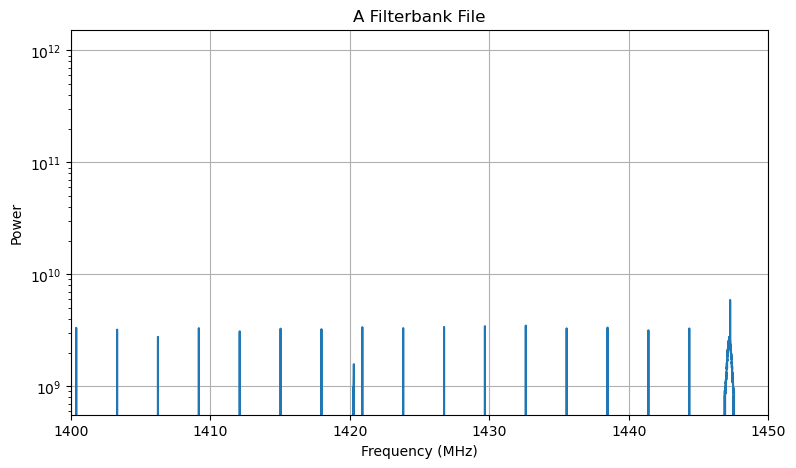

In [6]:
plt.figure(figsize=(9,5)) 
plt.plot(freqs, data[260]) 
plt.yscale('log')
plt.xlim(1400,1450)
plt.grid()
plt.xlabel("Frequency (MHz)") 
plt.ylabel("Power")
plt.title("A Filterbank File")
plt.show()

Here, we try to seperate signal and fitting a profile. The profile gonna be fitting using either Voigt profile or the delta delta function. The decision is made based on the linewidth, and should be make the fitting process faster

We will save the amplitude, central freq, sigma, and start, end freq. The amplitude will be save as Lorentz amplitude, Gaussian amplitude and total amplitude. 

For the case of delta delta, we will assign the Gaussian amplitude and Lorentz amplitude to be 0 and the total amplitude is the value which we measure. The sigma is also save as the minimum spectral resolution as these signals might be too small to be resolve properly 

These will be the features used for training SOM.

In [8]:
#list of data need for saving, 
dname = ['ampG','cen','sigmaG','ampL','sigmaL','amp','FWHM']

In [9]:
# Voigt profile fitting
def _1Voigt(x, ampG1, cen, sigmaG1, ampL1, widL1):
    return (ampG1*(1/(sigmaG1*(np.sqrt(2*np.pi))))*(np.exp(-((x-cen)**2)/((2*sigmaG1)**2)))) +\
              ((ampL1*widL1**2/((x-cen)**2+widL1**2)))

def Gaussian(x, amp, cen, sigma):
    return amp*np.exp(-((x-cen)**2)/((2*sigma)**2))

def delta(x, cen, amp):
    return amp*(x == cen)

In [10]:
# Voigt decomposition, as their can be multiple line blend into each other.
def Voigt_fitting(freqs, I, p0, bounds):
    popt_1voigt, pcov_1voigt = scipy.optimize.curve_fit(_1Voigt, freqs, I, p0 = p0, bounds = bounds, method = 'trf')
    return popt_1voigt, pcov_1voigt

def Gaussian_fitting(freqs, I):
    popt_1voigt, pcov_1voigt = scipy.optimize.curve_fit(Gaussian, freqs, I)
    return popt_1voigt, pcov_1voigt

In [11]:
def Voigt_decomp(freqs, I, gain = 0.8, niter = 100, snr = 3):
    freqs = np.array(freqs)
    I = np.array(I)
    res = np.abs(freqs[1] - freqs[0])
    
    ampG = np.array([])
    cen = np.array([])
    sigmaG = np.array([])
    ampL = np.array([])
    sigmaL = np.array([])

    model = np.zeros_like(I)
    residue = I
    noise = 1e3
    peak = np.max(I)

    i = 0
    
    while (peak >= snr*noise and i <= niter):

        ampG1, ampL1 = peak*0.2, peak*0.8
        cen1 = freqs[np.where(I == peak)][0]
        sigmaG1, sigmaL1 = np.abs((freqs[-1]-freqs[0])/2.35), np.abs((freqs[-1]-freqs[0])/2.35)
        
        p0 = [ampG1, cen1, sigmaG1, ampL1, sigmaL1]
        upper = [peak, np.max(freqs), res*len(freqs)*2, peak, res*len(freqs)]
        lower = [0, np.min(freqs), res/2, 0.2*peak, res/2]
        bounds = (lower, upper)

        try:
            popt_1voigt, pcov_1voigt = Voigt_fitting(freqs,residue,p0, bounds)
            popt_1voigt[0] = gain*popt_1voigt[0]
            popt_1voigt[3] = gain*popt_1voigt[3]
        except:
            try:
                popt_1voigt, pcov_1voigt = Gaussian_fitting(freqs,residue, bounds = (lower[0:3],upper[0:3]))
                popt_1voigt = np.append(popt_1voigt,[0.0,0.0],axis = 0)
                popt_1voigt[0] = gain*popt_1voigt[0]
                popt_1voigt[3] = gain*popt_1voigt[3]
            except:
                #delta delta fit
                popt_1voigt = [0, peak, res/2, peak, res/2]
                popt_1voigt[0] = gain*popt_1voigt[0]
                popt_1voigt[3] = gain*popt_1voigt[3]

                    
        pars_1 = popt_1voigt
        voigt = _1Voigt(freqs, *pars_1)
        
        residue = residue - voigt
        model = model + voigt
        noise = 1e3
        i += 1
        
        loc = np.where(np.abs(cen - popt_1voigt[0]) <= res/2)
        ampG = np.append(ampG,popt_1voigt[0])
        cen = np.append(cen,popt_1voigt[1])
        sigmaG = np.append(sigmaG,popt_1voigt[2])
        ampL = np.append(ampL,popt_1voigt[3])
        sigmaL = np.append(sigmaL, popt_1voigt[4])
        #else:
        #    ampG[loc] += popt_1voigt[0]
        #    ampL[loc] += popt_1voigt[3]
    #print('param:',ampG, cen, sigmaG, ampL, sigmaL)
    return ampG, cen, sigmaG, ampL, sigmaL

In [12]:
def Decomp(freqs, I, gain = 0.7, niter = 100, snr = 3):
    freqs = np.array(freqs)
    I = np.array(I)
    dIdf = np.diff(I,prepend = I[0])
    res = np.abs(freqs[0]-freqs[1])/2

    ampG = np.array([])
    cen = np.array([])
    sigmaG = np.array([])
    ampL = np.array([])
    sigmaL = np.array([])

    residue = I
    model = np.zeros_like(I)
    
    start = 0
    i = 1
    while i < len(freqs)-1:
        i += 1
        if ((dIdf[i] > 0) and (dIdf[i-1] < -1e3)):
            stop = i
            if stop-start == 3:
                func = np.zeros_like(I)
                ampG1, cen1, sigmaG1, ampL1, sigmaL1 = [0.0], [freqs[i-1]], [res/2], [residue[i] - (residue[i-2] + residue[i])/2], [res/2]
                func = delta(freqs,cen1,ampL1)
                i = 1
            
            elif i == len(freqs) - 1:
                ampG1, cen1, sigmaG1, ampL1, sigmaL1 = Voigt_decomp(freqs[start:stop], I[start:stop], gain = gain, niter = 100, snr = snr)
                for j in range(len(ampG)):
                    if ampG[i] == 0:
                        func += delta(freqs, cen1[i], ampL1[i])
                    else:
                        func += _1Voigt(freqs, ampG1[i], cen1[i], sigmaG1[i], ampL1[i], sigmaL1[i])
            
            else:
                ampG1, cen1, sigmaG1, ampL1, sigmaL1 = Voigt_decomp(freqs[start:stop], I[start:stop], gain = gain, niter = 100, snr = snr)
                func = np.zeros_like(I)
                for j in range(len(ampG)):
                    if ampG[i] == 0:
                        func += delta(freqs, cen1[i], ampL1[i])
                    else:
                        func += _1Voigt(freqs, ampG1[i], cen1[i], sigmaG1[i], ampL1[i], sigmaL1[i])
                i = 1
            
            ampG = np.append(ampG,ampG1,axis = 0)
            cen = np.append(cen,cen1,axis = 0)
            sigmaG = np.append(sigmaG,sigmaG1,axis = 0)
            ampL = np.append(ampL,ampL1,axis = 0)
            sigmaL = np.append(sigmaL,sigmaL1,axis = 0)

            model = model + func
            residue = residue - func
        if max(residue) < snr*1e3:
            break
            
    return ampG,cen,sigmaG,ampL,sigmaL

In [13]:
# calculate FWHM, and total Amplitude
def Voigt_FWHM(sigmaG, sigmaL):
    FWHMG = 2*sigmaG*np.sqrt(2*np.log(2))
    FWHML = 2*sigmaL
    return 0.5343*FWHML + np.sqrt(0.2169*FWHML**2 + FWHMG**2)

In [14]:
# Signal seperation, fitting and saving
# We will seperate the signals into smaller part by splicing them between 2 zeros
def spec_sep(freqs, I, gain = 0.7, niter = 1000, snr = 3):
    freqs = np.array(freqs)
    I = np.array(I)
    
    ampG = np.array([])
    cen = np.array([])
    sigmaG = np.array([])
    ampL = np.array([])
    sigmaL = np.array([])
    res = np.abs((freqs[0] - freqs[1])/2)


    dfreqs = [freqs[0]]
    dI = [0.0]
    
    for i in range(1,len(freqs)-1):
        if I[i] > 0:
            dfreqs.append(freqs[i])
            dI.append(I[i])
        elif (I[i-1] == 0 and I[i] == 0):
            dfreqs = [freqs[i]]
            dI = [0]
        elif (I[i-1] > 0 and I[i] == 0):
            dfreqs.append(freqs[i])
            dI.append(0.0)

            #fit the spectrum
            if len(dfreqs) > 3:
                #fit Voigt profile
                ampG1, cen1, sigmaG1, ampL1, sigmaL1 = Voigt_decomp(dfreqs, dI, gain = 0.7)
            else:
                #fit delta profile
                ampG1, cen1, sigmaG1, ampL1, sigmaL1 = np.array([0]), np.array([dfreqs[1]]), np.array([res/2]), np.array([np.max(dI)]), np.array([res/2])


            ampG = np.append(ampG,ampG1)
            cen = np.append(cen,cen1)
            sigmaG = np.append(sigmaG,sigmaG1)
            ampL = np.append(ampL,ampL1)
            sigmaL = np.append(sigmaL,sigmaL1)

            #reset the spectrum
            dfreqs = [freqs[i]]
            dI = [0.0]

        
    return ampG, cen, sigmaG, ampL, sigmaL

In [15]:
#Test
#mask_test_data = np.where(data[10] <= 10)
#test_data[mask_test_data] = 0

t = np.array([])
ampG = np.array([])
cen = np.array([])
sigmaG = np.array([])
ampL = np.array([])
sigmaL = np.array([])

for i in range(0,250,10):
    print(i+1,'/273')
    t = np.append(t, np.ones_like(sigmaG1)*time[i])
    ampG1, cen1, sigmaG1, ampL1, sigmaL1 = spec_sep(freqs,data[i])
    ampG = np.append(ampG,ampG1)
    cen = np.append(cen,cen1)
    sigmaG = np.append(sigmaG,sigmaG1)
    ampL = np.append(ampL,ampL1)
    sigmaL = np.append(sigmaL,sigmaL1)
    print(len(ampG))

out = pd.DataFrame(np.array([cen, ampG, sigmaG, ampL,sigmaL]), columns = ['cen','ampG', 'sigmaG', 'ampL', 'sigmaL'])
out['FWHM'] = Voigt_FWHM(sigmaG,sigmaL)
out['Amp'] = ampG + ampL

out.to_csv('line_fit.csv')

1 /273


/tmp/ipykernel_44050/2840582656.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_1voigt, pcov_1voigt = scipy.optimize.curve_fit(_1Voigt, freqs, I, p0 = p0, bounds = bounds, method = 'trf')


63025
11 /273
126325
21 /273
187273
31 /273
251842
41 /273
317497
51 /273
382466
61 /273
450745
71 /273
513200
81 /273
577571
91 /273
640534
101 /273
705666
111 /273
775044
121 /273
843756
131 /273
911253
141 /273
982261
151 /273
1050370
161 /273
1115774
171 /273
1177391
181 /273
1241959
191 /273
1313810
201 /273
1380058
211 /273
1447727
221 /273
1521901
231 /273
1588261
241 /273
1663864


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

In [27]:
out = pd.DataFrame({'cen':cen})

out['ampG'] = ampG
out['sigmaG'] = sigmaG
out['ampL'] = ampL
out['sigmaL'] = sigmaL
out['FWHM'] = Voigt_FWHM(sigmaG,sigmaL)
out['Amp'] = ampG + ampL

out.to_csv('line_fit.csv')